In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import squidpy as sq
import scanpy as sc
import os

In [20]:
adata=sc.read('../../data/processed_adata/'+'/adata_msbrain_3rep_withclusters_only_nuclei_deep_annotation_with_colors.h5ad')
adata

AnnData object with n_obs × n_vars = 82941 × 284
    obs: 'ind', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'graph_clusters', 'kmeans2_clusters', 'kmeans3_clusters', 'kmeans4_clusters', 'kmeans5_clusters', 'kmeans6_clusters', 'kmeans7_clusters', 'kmeans8_clusters', 'kmeans9_clusters', 'kmeans10_clusters', 'replicate', 'n_counts', 'leiden_2_2', 'leiden_1_8', 'leiden_1_4', 'leiden_1_0', 'leiden_0_8', 'leiden_0_6', 'cell_code', 'expanded_class', 'expanded_initial_annotation', 'Class', 'initial_annotation', 'celltype_annotation', 'X', 'Y', 'leiden_0_4', 'leiden_0_2', 'Class_old', 'class_number'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Class_colors', 'celltype_annotation_colors', 'dendrogram_celltype_annotation', 'dendrogram_initial_annotation', 'expanded_class_colors', 'expanded_initial_annotation_colors', 'hvg', 'initial_annotation_colors

In [21]:
adata.obsm["spatial"]=np.array([adata.obs.X,adata.obs.Y]).transpose().astype('float64')

In [22]:
adata=adata[adata.obs['replicate']=='1']

1


/home/sergioms/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


<Figure size 10000x10000 with 0 Axes>

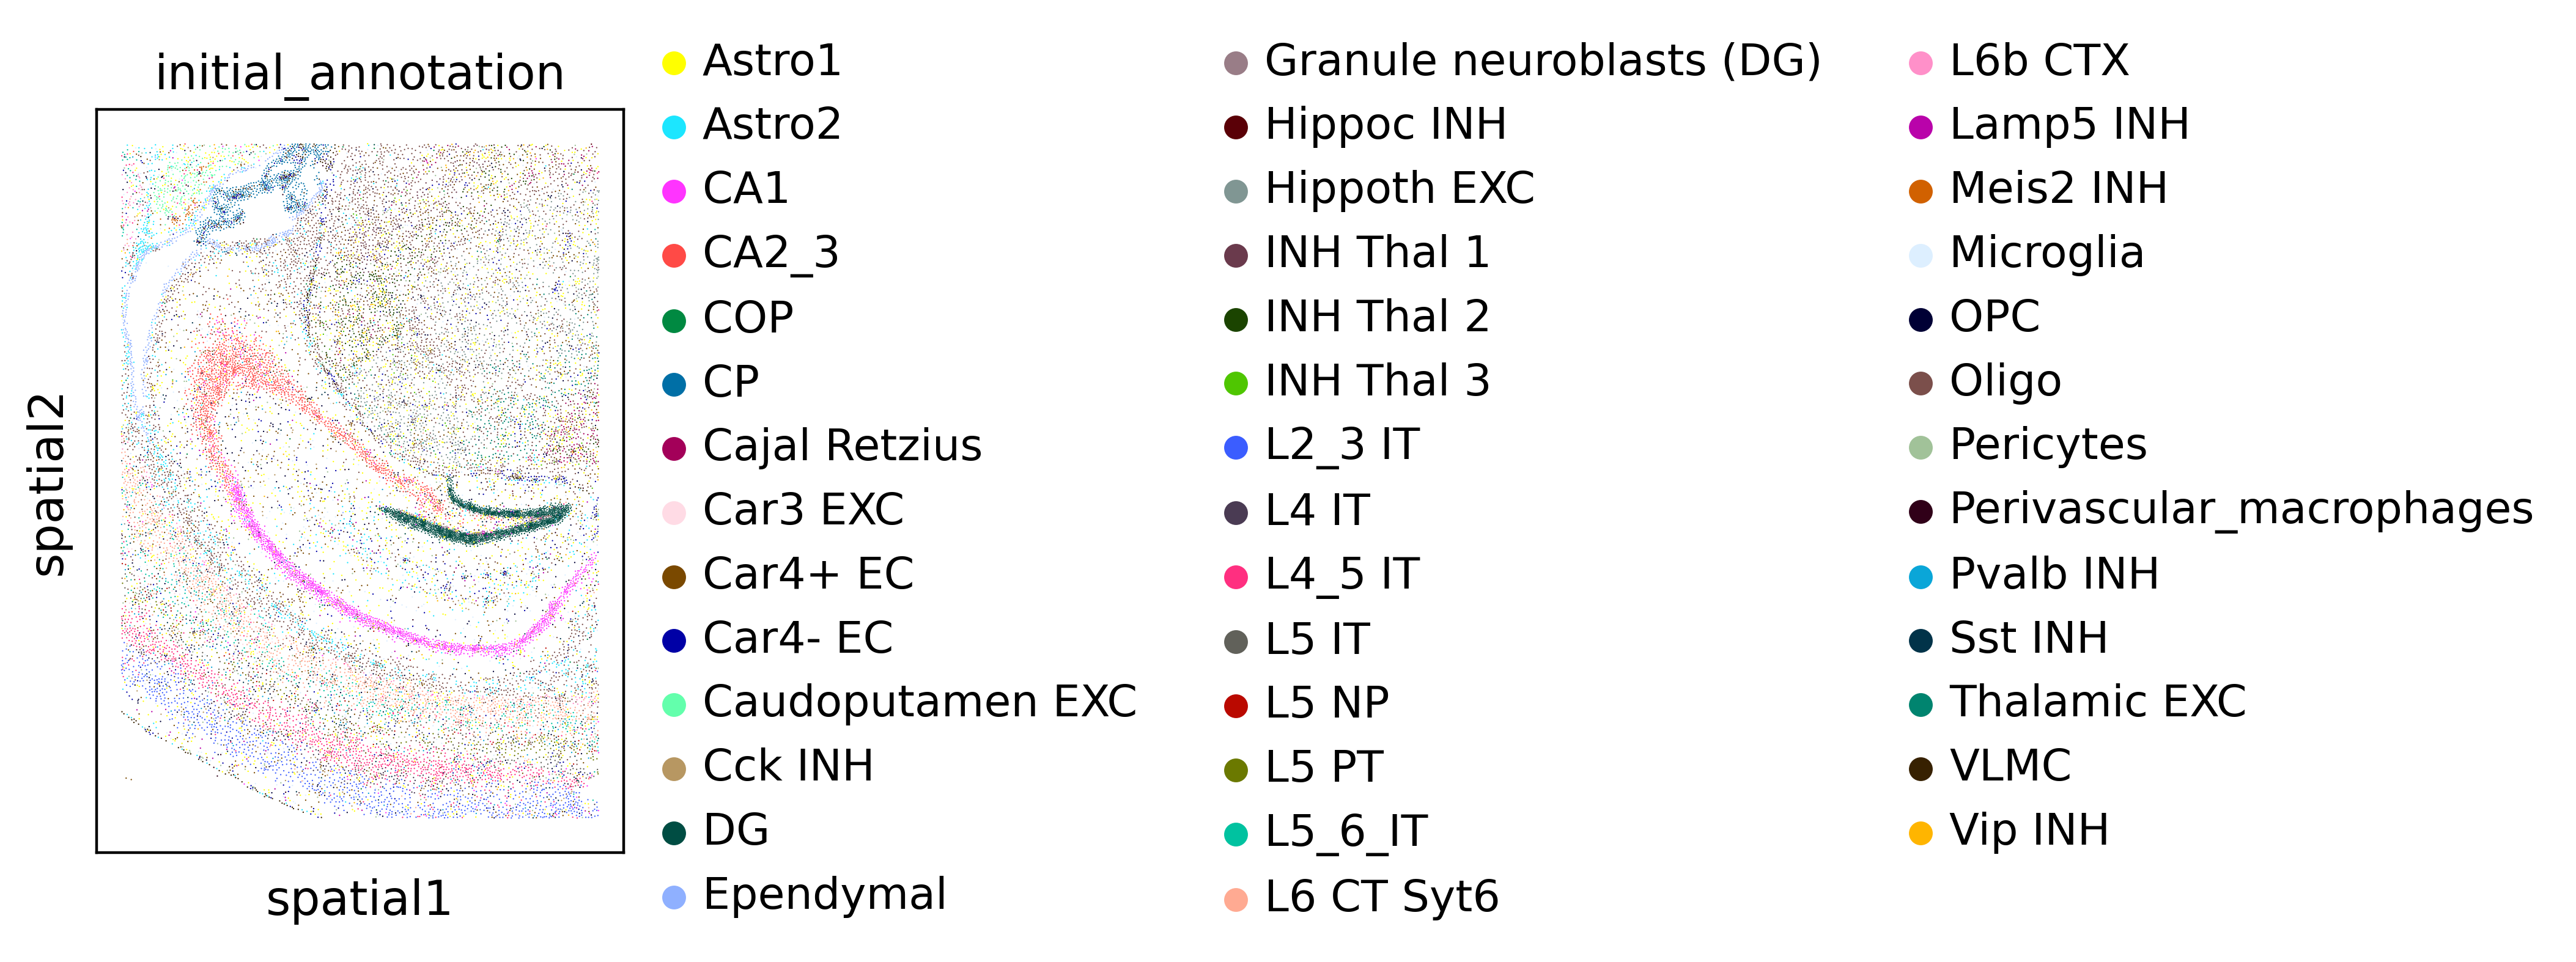

In [23]:
for samp in adata.obs['replicate'].unique():
    asub=adata[adata.obs['replicate']==samp]
    print(samp)
    plt.figure(figsize=(50,50))
    sc.pl.spatial(
    asub,
    color="initial_annotation",
    neighbors_key="spatial_neighbors",
    spot_size=40,
    edges=False,
    edges_width=2,
    img_key=None,
    )

In [24]:
ad=adata
anndata_list = []
for sample in ad.obs['replicate'].unique():
    adata_copy_int = ad[ad.obs['replicate'] == sample ]
    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['replicate'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])
    sq.gr.spatial_neighbors(adata_copy_int,radius=200.0,coord_type='generic')
    arrs=((adata_copy_int.obsp['spatial_distances']>0).toarray())*1
    datf=pd.DataFrame(arrs)
    datf['key']=list(adata_copy_int.obs['initial_annotation'])
    neighmatrix=datf.groupby('key').sum().transpose()
    adataneigh=sc.AnnData(neighmatrix)
    adataneigh.obs=adata_copy_int.obs
    adataneigh.obs['counts']=list(np.sum(neighmatrix,axis=1))
    anndata_list.append(adataneigh)
ad_sp_concat = sc.concat(anndata_list, pairwise=True,join='outer')

/tmp/ipykernel_854/3883178479.py:11: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adataneigh=sc.AnnData(neighmatrix)


In [25]:
adataneigh=ad_sp_concat#[:,ad_sp_concat.var.index.isin(['MES_like','Cycling','OPC_like','AC_like','OC_like'])]
adataneigh.obsm["spatial"]=np.array([adataneigh.obs.X,adataneigh.obs.Y]).transpose().astype('float64')
adataneigh.X=np.nan_to_num(adataneigh.X)

In [26]:
adataneigh

AnnData object with n_obs × n_vars = 25695 × 41
    obs: 'ind', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'graph_clusters', 'kmeans2_clusters', 'kmeans3_clusters', 'kmeans4_clusters', 'kmeans5_clusters', 'kmeans6_clusters', 'kmeans7_clusters', 'kmeans8_clusters', 'kmeans9_clusters', 'kmeans10_clusters', 'replicate', 'n_counts', 'leiden_2_2', 'leiden_1_8', 'leiden_1_4', 'leiden_1_0', 'leiden_0_8', 'leiden_0_6', 'cell_code', 'expanded_class', 'expanded_initial_annotation', 'Class', 'initial_annotation', 'celltype_annotation', 'X', 'Y', 'leiden_0_4', 'leiden_0_2', 'Class_old', 'class_number', 'counts'
    obsm: 'spatial'

In [27]:
adataneigh=adataneigh[adataneigh.obs['counts']>3]

In [28]:
adataneigh

View of AnnData object with n_obs × n_vars = 25134 × 41
    obs: 'ind', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'graph_clusters', 'kmeans2_clusters', 'kmeans3_clusters', 'kmeans4_clusters', 'kmeans5_clusters', 'kmeans6_clusters', 'kmeans7_clusters', 'kmeans8_clusters', 'kmeans9_clusters', 'kmeans10_clusters', 'replicate', 'n_counts', 'leiden_2_2', 'leiden_1_8', 'leiden_1_4', 'leiden_1_0', 'leiden_0_8', 'leiden_0_6', 'cell_code', 'expanded_class', 'expanded_initial_annotation', 'Class', 'initial_annotation', 'celltype_annotation', 'X', 'Y', 'leiden_0_4', 'leiden_0_2', 'Class_old', 'class_number', 'counts'
    obsm: 'spatial'

In [32]:
adataneigh.raw=adataneigh
#sc.pp.normalize_total(adataneigh, target_sum=1e4)
#sc.pp.log1p(adataneigh)

In [33]:
sc.pp.neighbors(adataneigh, n_neighbors=8,n_pcs=20)
sc.tl.leiden(adataneigh,resolution=0.9,key_added='neighborhood_clusters')

In [34]:
sc.tl.umap(adataneigh,min_dist=0.1)
sc.set_figure_params(scanpy=True, dpi=200)

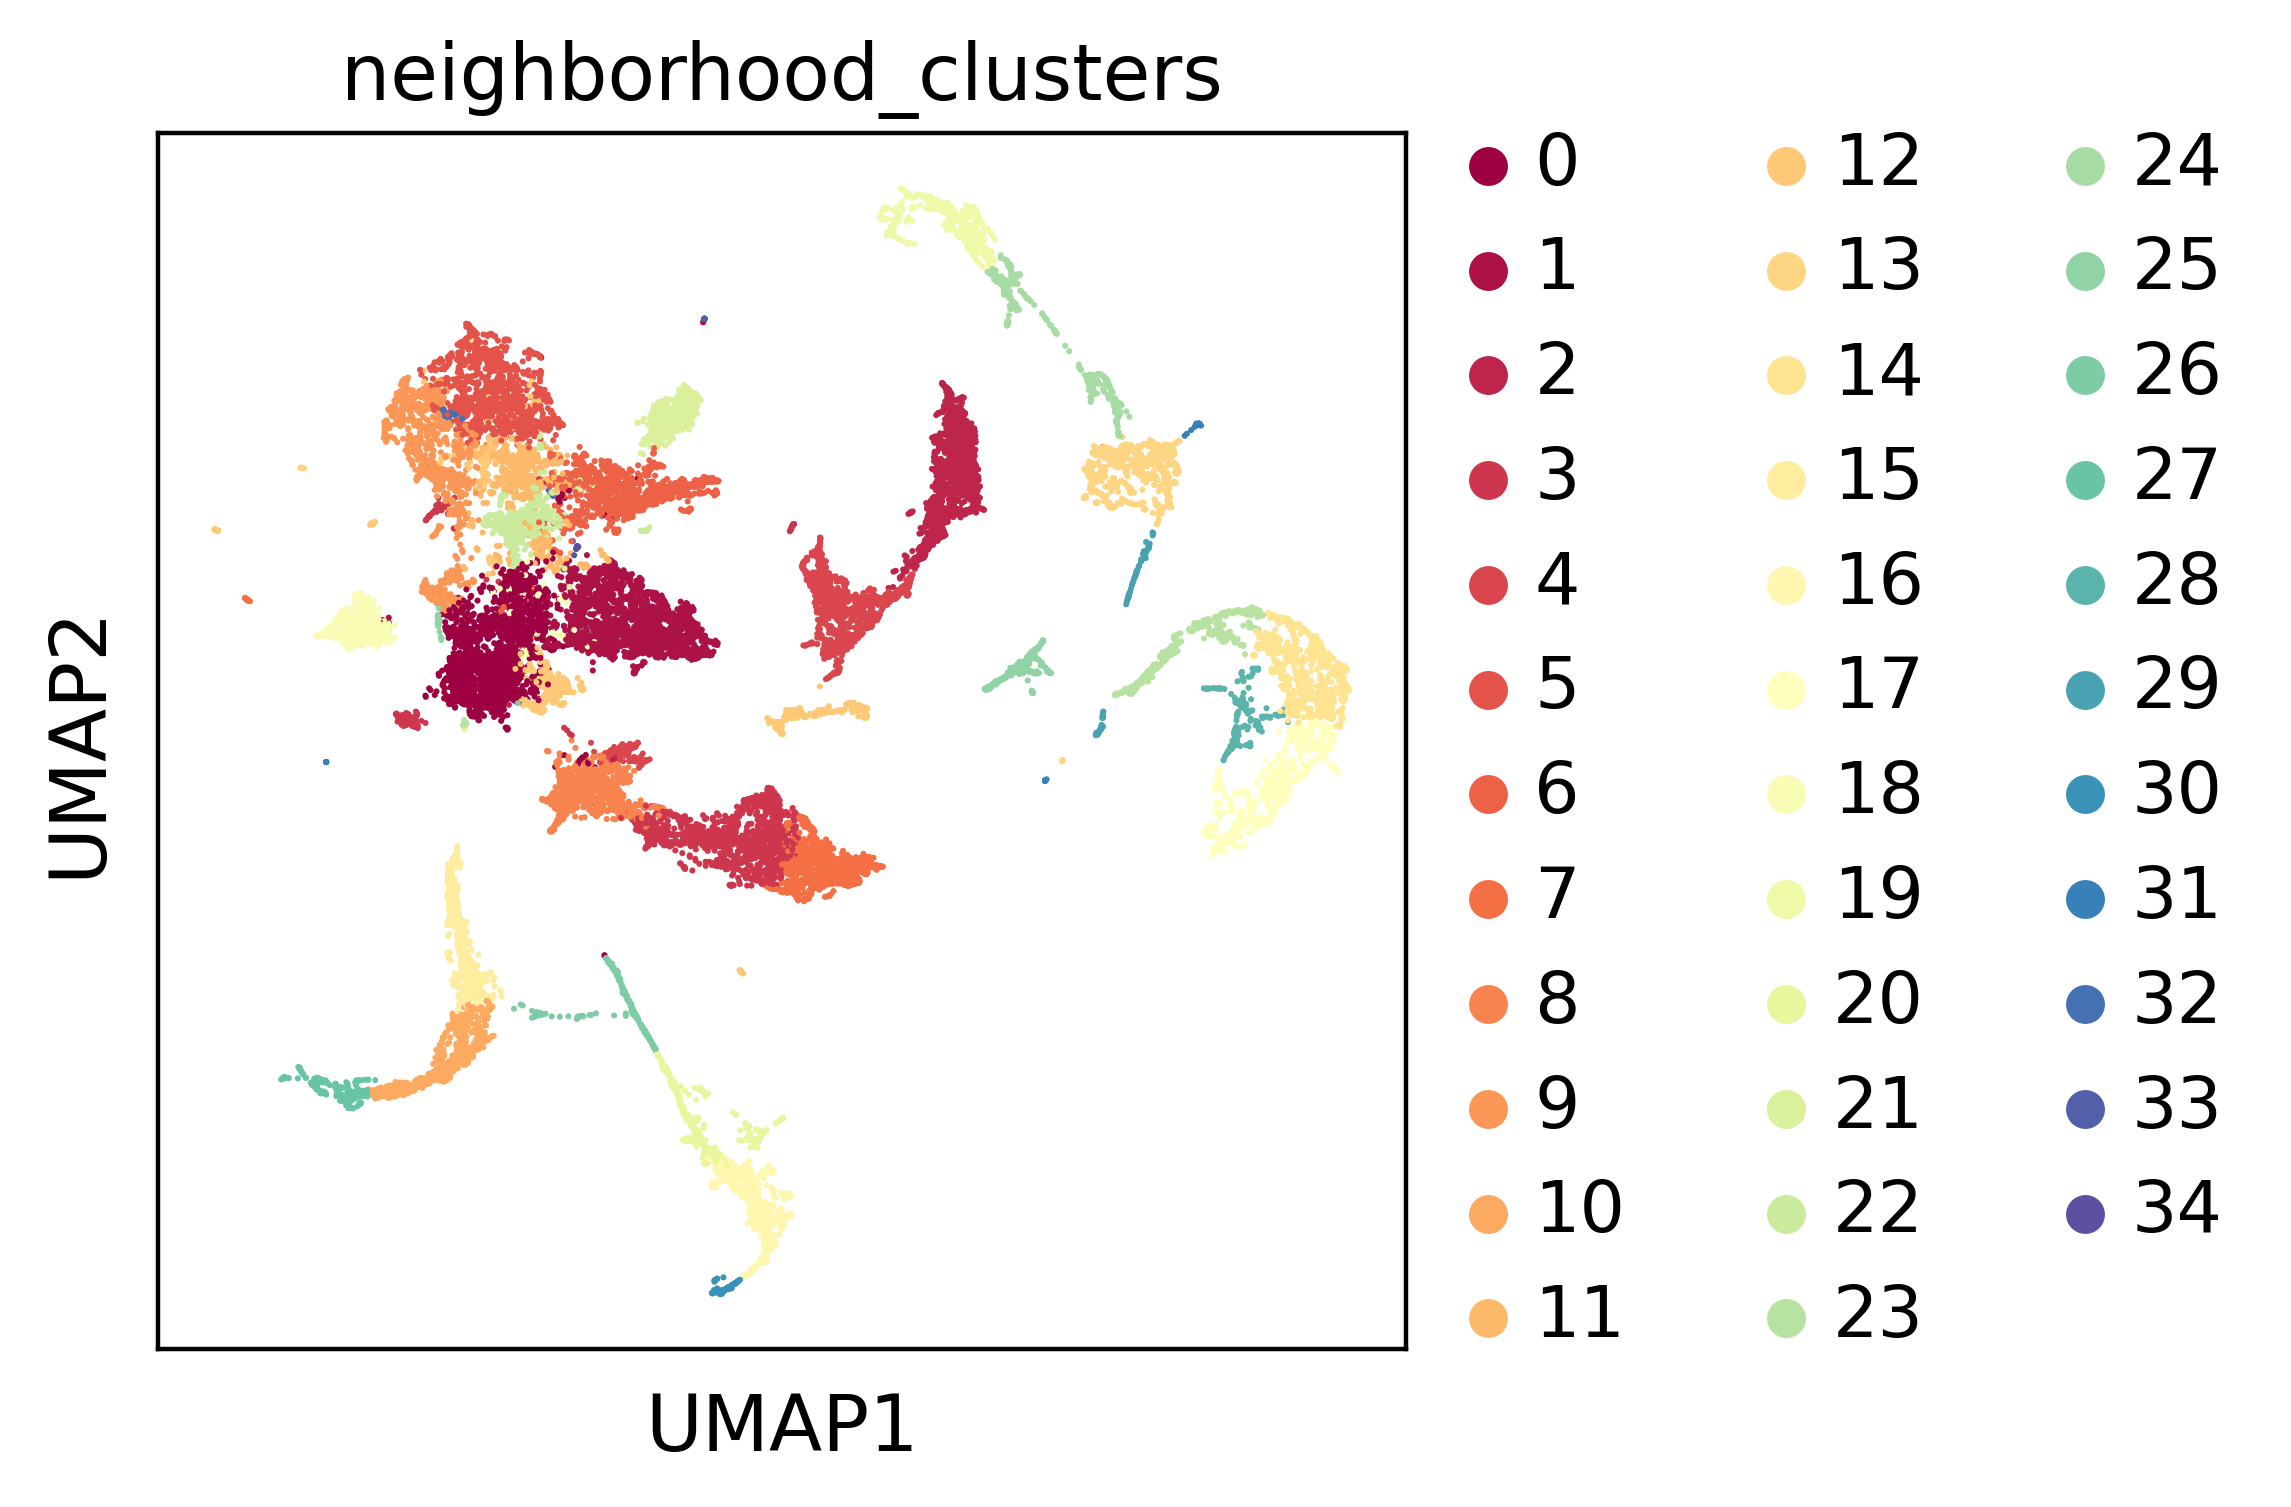

In [35]:
sc.pl.umap(adataneigh,color=['neighborhood_clusters'],palette='Spectral')#,save='UMAP_10X_colors.svg')

In [36]:
adataneigh.write('../../figures/7.spatial_architecture/'+'/adata_msbrain_3rep_withclusters_neighbors_domains_rep1.h5ad')